# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the Pendulum-v1 environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. This Jupyter notebook contains our implementation and report for this project. 

The instructions are available in `Miniproject_DDPG.pdf` file.

## Heuristic policy

In [1]:
import numpy as np
import gym
from helpers import NormalizedEnv
from helpers import RandomAgent

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


In [20]:
# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1')
env = NormalizedEnv(env)

# Create a RandomAgent
random_agent = RandomAgent(env)

# Function that run the agent for a given number of episodes and return the average reward
def run_agent(agent, env, num_episodes):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)
average_reward = run_agent(random_agent, env, 10)
print('Average reward over 10 episodes: {}'.format(average_reward))

Average reward over 10 episodes: -1240.0024725455646


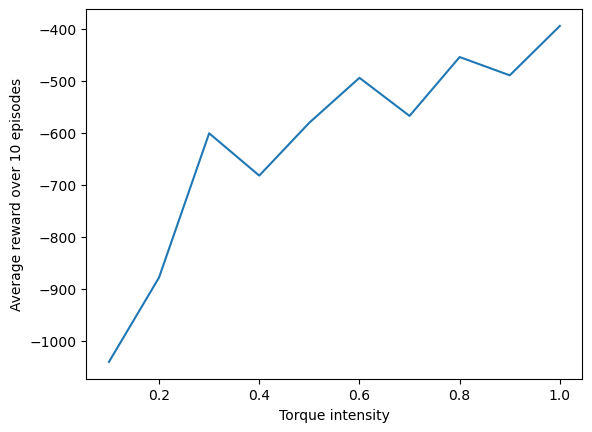

Best torque intensity: 1.0
Best reward over 10 episodes: -394.4065986195579


In [32]:
class HeuristicPendulumAgent:
    def __init__(self, env, torque_intensity=1.0):
        """Heuristic agent for the Pendulum-v1 environment.

        Args:
            torque_intensity (float): Intensity of the torque applied to the pendulum
        """
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state):
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        if state[0] < 0: # If the pendulum is in the lower half of the circle
            return np.sign(state[2]) * self.torque_intensity
        else:
            return -np.sign(state[2]) * self.torque_intensity

# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average reward over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


## Q function of the heuristic policy

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        """Replay buffer used to store a sequence of transitions.

        A transition is a tuple of the form (state, action, reward, next_state, trunc).

        Args:
            max_size (int): Maximum size of the buffer
        """
        self.max_size = max_size
        self.buffer = []

    def store(self, transition):
        """Store a transition in the buffer.

        Args:
            transition (tuple): Transition to store
        """
        self.buffer.append(transition)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)

    def sample(self, batch_size):
        """Sample a batch of transitions from the buffer.

        Args:
            batch_size (int): Size of the batch to sample

        Returns:
            batch (list): List of transitions
        """
        batch = []
        idxs = np.random.randint(0, len(self.buffer), size=batch_size)
        for idx in idxs:
            batch.append(self.buffer[idx])
        return batch


class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        """QNetwork. Maps (state, action) pairs to Q-values.

        Args:
            state_size (int): Size of the state space
            action_size (int): Size of the action space
        """
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.fc1 = nn.Linear(self.state_size + self.action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def TD_learning_update(q_network, optimizer, replay_buffer, learning_rate):
    """Perform a TD-learning update.

    Args:
        q_network (QNetwork): QNetwork instance
        optimizer (torch.optim): Optimizer instance
        replay_buffer (ReplayBuffer): ReplayBuffer instance
        learning_rate (float): Learning rate

    Returns:
        loss (float): Loss value
    """
    # Sample a batch of transitions
    batch = replay_buffer.sample(64)
    # Convert the batch to tensors
    batch = [torch.tensor(transition, dtype=torch.float32) for transition in batch]
    # Unpack the batch
    states, actions, rewards, next_states, truncs = batch
    # Compute the target Q-values
    with torch.no_grad():
        target_q_values = rewards + (1 - truncs) * learning_rate * torch.max(q_network(next_states, q_network(next_states, actions)), dim=1)[0]
    # Compute the current Q-values
    current_q_values = q_network(states, actions)
    # Compute the loss
    loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
    # Perform a gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)